### Quantitative methods – Written investigation

Student number: 21159916

**Import and set up packages necessary for analysis**

In [1]:
# Import packages required for analysis
import pandas as pd

In [ ]:
# Import package required for accessing installed modules
import sys

In [ ]:
# Import packages required for data visualisation
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
# Import packages required for numeric operations
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
# Install package necessary to read ODS files, Jonathan Reades's docker image is lacking this package
if "odfpy" not in sys.modules:
    %pip install odfpy

Note: you may need to restart the kernel to use updated packages.


**Extract average_death_count variable**

The Office for National Statistics contains information about weekly deaths in British care homes.

The following operation extracts this information and places it in a dataframe.

Source: https://data.london.gov.uk/download/coronavirus--covid-19--deaths/87b3bb8d-e81a-48ea-bfb7-45fa2d01cd4b/ons_deaths_weekly_occurrences_by_la_location.csv

In [3]:
# Read in weekly death count data for Biritsh care homes
weekly_readings = pd.read_csv("ons_deaths_weekly_occurrences_by_la_location.csv")

In [4]:
# Extract dataframe that contains only care home readings
care_home_weekly_readings = weekly_readings[weekly_readings['place_of_death'] == 'Care home']

In [5]:
# Extract dataframe that contains only COVID 19 related care home readings
covid_care_home_weekly_readings = care_home_weekly_readings[care_home_weekly_readings['cause_of_death'] == 'COVID 19']

In [7]:
# Extract only those readings that contain at least 1 COVID 19 death
covid_care_home_weekly_deaths = covid_care_home_weekly_readings[covid_care_home_weekly_readings['deaths'] != 0]

In [8]:
# Group data frame by area_name
average_death_count = covid_care_home_weekly_deaths.groupby('area_name', as_index=False)['deaths'].mean()

In [9]:
# Rename columns
average_death_count.columns = ['Area', 'average_death_count']

**Extraction of independent variables**

**Common functionality**

In [ ]:
# This function will 'melt' data frames by compressing each colum that contains
# weekly data into a single column containing a list of weekly data

def aggregate_weekly_data(data_frame, identity_variables, value_name):
    # The dataframe has columns for each week, these need to be aggregated.
    # The first 5 columns remain as identifiers for each row
    data_frame = data_frame.melt(id_vars=identity_variables,
                                 var_name="Date",
                                 value_name=value_name)
    return data_frame

In [ ]:
# This function will remove suppressed '[s]' and missing '[n]' data values
# and will convert a data frame column into a float and remove all other columns aside from
# the key (which is 'area') amd the specified column

def clean_data(data_frame, column_name):
    data_frame = data_frame[data_frame[column_name] != "[s]"]
    data_frame = data_frame[data_frame[column_name] != "[n]"]
    data_frame[column_name] = data_frame[column_name].astype(float)
    data_frame = data_frame[['Area', column_name]]
    return data_frame

In [14]:
# This function will return the mean value of the weekly vaccination rate of care homes in British local authorities
# It will be used to calculate mean weekly increases for both resident and staff care home vaccination rates

def get_mean_increase(vaccination_rates_dataframe):
    # The weekly increases in vaccination rates need to be calculated and then a mean value has to be assigned to each 'Area'
    # This list represents the mean increase in vaccination rates
    mean_increase = []
    # Looping through the table of areas in the UK
    for index, row in vaccination_rates_dataframe.iterrows():
        # Represents total increase for a given row
        total_increases = 0
        # Extracts compressed list of vaccination percentages for each area
        row = row['Vaccination Percentage']
        # Loops through each vaccination percentage
        for percentage in row:
            # Resets the value of the last percentage increase to zero
            last_increase = 0
            # Gets the index of the current vaccination rate percentage
            index2 = row.index(percentage)
            # Converts index to integer
            index2 = int(index2)
            # If this is not the first element in the list then the last increase variable can be derived
            if index2 > 0:
                last_increase = row[index2-1]
            # After this the difference can be calculated and added to the total increase in weekly vaccination rates
            difference = percentage - last_increase
            total_increases = total_increases + difference
        # Finally a mean percentage increase can be calculated for the area
        mean_increase.append(total_increases/(len(row)))
    return mean_increase

In [ ]:
# This function will determine the mean percentage of British care homes that made a specific policy based decision in a local authority

def get_mean_percentage(data_frame, column_name):
    mean_percentage = []
    for row in data_frame.iterrows():
        percentage_list = row[1][column_name]
        mean_percentage.append(sum(percentage_list)/len(percentage_list))
    return mean_percentage

**Extract variables representing weekly increases in vaccination rates for reidents and staff in British care homes (resident_vaccination_rate_increase and staff_vaccination_rate_increase)**

Data Source: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1032732/covid-vaccination-november-2021.ods

In order to extract the vaccination data for residents and staff at British care homes the excel file from the above data source need to be read in and cleaned.

After which data regarding weekly vaccination rates will be read in for both residents and staff and the weekly percentage change will be calculated for both and placed into a dataframe.

In [10]:
# Extract data from relevant excel sheet
vaccination_data_older_patients = pd.read_excel("covid-vaccination-november-2021.ods",
                                                sheet_name="Table_1",
                                                skiprows=[0, 1],
                                                engine="odf")
vaccination_data_older_patients = vaccination_data_older_patients[vaccination_data_older_patients['Dose'] == 'One']
vaccination_data_older_patients = vaccination_data_older_patients[vaccination_data_older_patients['Area unit'] == 'Local Authority']

In [11]:
# The dataframe has columns for each week, these need to be aggregated.
# The first 5 columns remain as identifiers for each row
# The weekly vaccination rates are compressed into a list which is placed into a single column
identity_variables = ["Area", "Area Code", "Area unit", "Dose", "Description"]
vaccination_data_older_patients = aggregate_weekly_data(vaccination_data_older_patients,
                                                        identity_variables,
                                                        "Vaccination Percentage")

In [12]:
# Remove missing and suppressed data, convert data type of column to float and return subsetted data frame
vaccination_data_older_patients = clean_data(vaccination_data_older_patients,
                                             'Vaccination Percentage')

In [13]:
# Now vaccination rates can be grouped by area and then aggregated across all weeks
grouped = vaccination_data_older_patients.groupby('Area', as_index=False)
resident_vaccination_rates = grouped.aggregate(lambda x: list(x))

In [ ]:
# Appying the common function defined above to resident vaccination rates yields
mean_increase = get_mean_increase(resident_vaccination_rates)

In [15]:
# A new variable can now be assigned to the data frame representing the mean weekly increase in vaccination percentages by area
resident_vaccination_rates['resident_vaccination_rate_increase'] = mean_increase

# Finally the columns used to derive the this new variable can be removed from the data frame
resident_vaccination_rates = resident_vaccination_rates[['Area', 'resident_vaccination_rate_increase']]

In [16]:
# Read in data about vaccination rates amongst care staff for older patients
vaccination_data_older_care_staff = pd.read_excel("covid-vaccination-november-2021.ods",
                                                  sheet_name="Table_2",
                                                  skiprows=[0, 1],
                                                  engine="odf")
vaccination_data_older_care_staff = vaccination_data_older_care_staff[vaccination_data_older_care_staff['Dose'] == 'One']
vaccination_data_older_care_staff = vaccination_data_older_care_staff[vaccination_data_older_care_staff['Area unit'] == 'Local Authority']

In [18]:
# The dataframe has columns for each week, these need to be aggregated.
# The first 5 columns remain as identifiers for each row
# The weekly vaccination rates are compressed into a list which is placed into a single column
identity_variables = ["Area", "Area Code", "Area unit", "Dose", "Description"]
vaccination_data_older_care_staff = aggregate_weekly_data(vaccination_data_older_care_staff,
                                                          identity_variables,
                                                          "Vaccination Percentage")

In [19]:
# Remove missing and suppressed data, convert data type of column to float and return subsetted data frame
vaccination_data_older_care_staff = clean_data(vaccination_data_older_care_staff,
                                               'Vaccination Percentage')

In [21]:
# Now vaccination rates can be grouped by area and then aggregated across all weeks
grouped = vaccination_data_older_care_staff.groupby('Area', as_index=False)
staff_vaccination_rates = grouped.aggregate(lambda x: list(x))

In [ ]:
# Appying the common function defined above to staff vaccination rates yields
mean_increase = get_mean_increase(staff_vaccination_rates)

In [23]:
# Now vaccination rates can be grouped by area and then aggregated across all weeks
staff_vaccination_rates['staff_vaccination_rate_increase'] = mean_increase
staff_vaccination_rates = staff_vaccination_rates[['Area', 'staff_vaccination_rate_increase']]

In [24]:
# Finally the data frames for mean resident and staff vaccination rate increases can be merged
vaccination_rates = resident_vaccination_rates.merge(staff_vaccination_rates,
                                                     on="Area")
vaccination_rates

,Area,resident_vaccination_rate_increase,staff_vaccination_rate_increase
0,Barking and Dagenham,2.167442,2.268889
1,Barnet,2.200000,2.076087
2,Barnsley,2.197778,2.133333
3,Bath and North East Somerset,2.357143,2.284091
4,Bedford,2.504878,2.351163
...,...,...,...
146,Wirral,2.167391,2.045652
147,Wokingham,3.259091,2.145652
148,Wolverhampton,2.193182,2.113043
149,Worcestershire,2.245652,2.119565


**Extract independent variables from policy dataset**

Data Source: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1032737/infection-control-november-2021.ods

**Extract mean weekly percentage of care homes that allowed visiting vairable (visiting_allowed_percentage)**

In [25]:
# Extract data from relevant excel sheet
visting_allowed_percentage = pd.read_excel("infection-control-november-2021.ods",
                                           sheet_name="Table_1",
                                           skiprows=[0, 1],
                                           engine="odf")

In [ ]:
# Filter data frame to ensure only percentage values of local authority care homes where visiting is allowed are taken
visting_allowed_percentage = visting_allowed_percentage[visting_allowed_percentage['Measure'] == "Percentage of care homes"]
visting_allowed_percentage = visting_allowed_percentage[visting_allowed_percentage['Area unit'] == 'Local Authority']
visting_allowed_percentage = visting_allowed_percentage[visting_allowed_percentage['Description'] == 'Visiting is allowed']

In [26]:
# The dataframe has columns for each week, these need to be aggregated.
# The first 5 columns remain as identifiers for each row
# The weekly vaccination rates are compressed into a list which is placed into a single column
identity_variables = ["Area", "Area Code", "Area unit", "Measure", "Description"]
visting_allowed_percentage = aggregate_weekly_data(visting_allowed_percentage,
                                                   identity_variables,
                                                   "visting_allowed_list")

In [27]:
# Remove missing and suppressed data, convert data type of column to float and return subsetted data frame
visting_allowed_percentage = clean_data(visting_allowed_percentage,
                                        'visting_allowed_list')

In [28]:
# Now visiting allowed percentages can be grouped by area and then aggregated across all weeks
grouped = visting_allowed_percentage.groupby('Area', as_index=False)
visting_allowed_percentage = grouped.aggregate(lambda x: list(x))

In [29]:
# Get the mean percentage of care homes in local authorties that allowed visiting
mean_percentage = get_mean_percentage(visting_allowed_percentage, 'visting_allowed_list')

In [30]:
# Assign the visiting allowed percentage column this value (replacing the list), remove additional columns from the data frame and display the data frame
visting_allowed_percentage['visting_allowed_percentage'] = mean_percentage
visting_allowed_percentage = visting_allowed_percentage[['Area', 'visting_allowed_percentage']]
visting_allowed_percentage

,Area,visting_allowed_percentage
0,Barking and Dagenham,74.073333
1,Barnet,63.247826
2,Barnsley,78.778261
3,Bath and North East Somerset,76.730435
4,Bedford,72.347826
...,...,...
146,Wirral,68.526087
147,Wokingham,85.352174
148,Wolverhampton,67.317391
149,Worcestershire,80.056522


**Extract mean weekly percentage of care homes that underpaid isolating staff (underpaid_islolating_staff_percentage)**

In [31]:
# Extract data from relevant excel sheet
isolating_staff_percentage = pd.read_excel("infection-control-november-2021.ods",
                                           sheet_name="Table_2",
                                           skiprows=[0, 1],
                                           engine="odf")

In [32]:
# Filter data frame to ensure only percentage values of local authority care homes where isolating staff are paid full wages
isolating_staff_percentage = isolating_staff_percentage[isolating_staff_percentage['Measure'] == "Percentage of care homes"]
isolating_staff_percentage = isolating_staff_percentage[isolating_staff_percentage['Area unit'] == 'Local Authority']
isolating_staff_percentage = isolating_staff_percentage[isolating_staff_percentage['Description'] == 'Isolating staff are paid full wages']

In [33]:
# The dataframe has columns for each week, these need to be aggregated.
# The first 5 columns remain as identifiers for each row
# The weekly vaccination rates are compressed into a list which is placed into a single column
identity_variables = ["Area", "Area Code", "Area unit", "Measure", "Description"]
isolating_staff_percentage = aggregate_weekly_data(isolating_staff_percentage,
                                                   identity_variables,
                                                   "isloating_staff_list")

In [34]:
# Remove missing and suppressed data, convert data type of column to float and return subsetted data frame
isolating_staff_percentage = clean_data(isolating_staff_percentage,
                                        'isloating_staff_list')

In [35]:
# Now isolating staff percentages can be grouped by area and then aggregated across all weeks
grouped = isolating_staff_percentage.groupby('Area', as_index=False)
isolating_staff_percentage = grouped.aggregate(lambda x: list(x))

In [36]:
# Get the mean percentage of care homes in local authorties that allowed visiting
mean_percentage = get_mean_percentage(isolating_staff_percentage, 'isloating_staff_list')

In [37]:
# Subtract the full paid isolating staff percentage from 100 to get the underpaid isolatin staff percentage
# (this covers all classifications of such underpaid staff and is more computationally efficient)
# Remove superflous columns and view the data frame
isolating_staff_percentage['full_paid_isloating_staff'] = mean_percentage
isolating_staff_percentage['underpaid_islolating_staff_percentage'] = 100 - isolating_staff_percentage['full_paid_isloating_staff']
isolating_staff_percentage = isolating_staff_percentage[['Area', 'underpaid_islolating_staff_percentage']]
isolating_staff_percentage

,Area,underpaid_islolating_staff_percentage
0,Barking and Dagenham,0.000000
1,Barnet,10.684783
2,Barnsley,45.115217
3,Bath and North East Somerset,6.908696
4,Bedford,21.354348
...,...,...
146,Wirral,12.973913
147,Wokingham,0.000000
148,Wolverhampton,30.569565
149,Worcestershire,19.741304


**Extract mean weekly percentage of care homes where staff worked in multiple locaitons (multiple_care_homes_worked_percentage)**

In [38]:
# Extract data from relevant excel sheet
carehomes_worked = pd.read_excel("infection-control-november-2021.ods",
                                 sheet_name="Table_3",
                                 skiprows=[0, 1],
                                 engine="odf")

In [39]:
# Filter data frame to ensure only percentage values of local authority care homes where staff didn't work in more than one care home
carehomes_worked = carehomes_worked[carehomes_worked['Measure'] == "Percentage of care homes"]
carehomes_worked = carehomes_worked[carehomes_worked['Area unit'] == 'Local Authority']
carehomes_worked = carehomes_worked[carehomes_worked['Description'] == 'No staff working between services']

In [40]:
# The dataframe has columns for each week, these need to be aggregated.
# The first 5 columns remain as identifiers for each row
# The weekly vaccination rates are compressed into a list which is placed into a single column
identity_variables = ["Area", "Area Code", "Area unit", "Measure", "Description"]
carehomes_worked = aggregate_weekly_data(carehomes_worked,
                                         identity_variables,
                                         "single_carehomes_worked_list")

In [41]:
# Remove missing and suppressed data, convert data type of column to float and return subsetted data frame
carehomes_worked = clean_data(carehomes_worked,
                              'single_carehomes_worked_list')

In [42]:
# Now care homes wokred percentages can be grouped by area and then aggregated across all weeks
grouped = carehomes_worked.groupby('Area', as_index=False)
carehomes_worked = grouped.aggregate(lambda x: list(x))

In [43]:
# Get the mean percentage of care homes in local authorties where staff worked in just a single care home
mean_percentage = get_mean_percentage(carehomes_worked, 'single_carehomes_worked_list')

In [44]:
# Subtract the full paid isolating staff percentage from 100 to get the multiple care homes wokred percentage for staff
# (this covers all classifications of such staff and is more computationally efficient)
# Remove superflous columns and view the data frame
carehomes_worked['single_carehomes_worked_list'] = mean_percentage
carehomes_worked['multiple_care_homes_worked_percentage'] = 100 - carehomes_worked['single_carehomes_worked_list']
carehomes_worked = carehomes_worked[['Area', 'multiple_care_homes_worked_percentage']]
carehomes_worked

,Area,multiple_care_homes_worked_percentage
0,Barking and Dagenham,29.143478
1,Barnet,23.397826
2,Barnsley,15.215217
3,Bath and North East Somerset,24.913043
4,Bedford,28.856522
...,...,...
146,Wirral,22.447826
147,Wokingham,23.119565
148,Wolverhampton,28.328261
149,Worcestershire,25.958696


**Extract mean weekly percentage of care homes where staff ratios were at risk (agreed_staffing_ratios_risk_percentage)**

In [45]:
# Extract data from relevant excel sheet
staffing_ratios = pd.read_excel("infection-control-november-2021.ods",
                                sheet_name="Table_4",
                                skiprows=[0, 1],
                                engine="odf")

In [46]:
staffing_ratios = staffing_ratios[staffing_ratios['Measure'] == "Percentage of care homes"]
staffing_ratios = staffing_ratios[staffing_ratios['Area unit'] == 'Local Authority']
staffing_ratios = staffing_ratios[staffing_ratios['Description'] == 'Agreed staffing ratios, no risk in coming days']

In [47]:
# The dataframe has columns for each week, these need to be aggregated.
# The first 5 columns remain as identifiers for each row
# The weekly vaccination rates are compressed into a list which is placed into a single column
identity_variables = ["Area", "Area Code", "Area unit", "Measure", "Description"]
staffing_ratios = aggregate_weekly_data(staffing_ratios,
                                        identity_variables,
                                        "agreed_staffing_ratios_no_risk_list")

In [48]:
# Remove missing and suppressed data, convert data type of column to float and return subsetted data frame
staffing_ratios = clean_data(staffing_ratios,
                             'agreed_staffing_ratios_no_risk_list')

In [49]:
# Now staffing ratios can be grouped by area and then aggregated across all weeks
grouped = staffing_ratios.groupby('Area', as_index=False)
staffing_ratios = grouped.aggregate(lambda x: list(x))

In [50]:
# Get the mean percentage of care homes in local authorties where there was no risk of lower staffing ratios
mean_percentage = get_mean_percentage(staffing_ratios, 'agreed_staffing_ratios_no_risk_list')

In [51]:
# Subtract the agreed staffing ratios no risk percentage from 100 to get the agreed staffing ratios at risk percentage
# (this covers all classifications of such staff and is more computationally efficient)
# Remove superflous columns and view the data frame
staffing_ratios['agreed_staffing_ratios_no_risk_list'] = mean_percentage
staffing_ratios['agreed_staffing_ratios_risk_percentage'] = 100 - staffing_ratios['agreed_staffing_ratios_no_risk_list']
staffing_ratios = staffing_ratios[['Area', 'agreed_staffing_ratios_risk_percentage']]
staffing_ratios

,Area,agreed_staffing_ratios_risk_percentage
0,Barking and Dagenham,0.000000
1,Barnet,0.563043
2,Barnsley,1.321739
3,Bath and North East Somerset,6.691304
4,Bedford,5.136957
...,...,...
146,Wirral,4.586957
147,Wokingham,0.000000
148,Wolverhampton,0.713043
149,Worcestershire,3.128261


**Merge dependent and independent variable data frames**

In [53]:
# Merge all data frames on the 'Area' column and view the data frame
merged_data_frame = vaccination_rates.merge(visting_allowed_percentage, on='Area')
merged_data_frame = merged_data_frame.merge(isolating_staff_percentage, on='Area')
merged_data_frame = merged_data_frame.merge(carehomes_worked, on='Area')
merged_data_frame = merged_data_frame.merge(staffing_ratios, on='Area')
merged_data_frame = merged_data_frame.merge(average_death_count, on='Area')
merged_data_frame

,Area,resident_vaccination_rate_increase,staff_vaccination_rate_increase,visting_allowed_percentage,underpaid_islolating_staff_percentage,multiple_care_homes_worked_percentage,agreed_staffing_ratios_risk_percentage,average_death_count
0,Barking and Dagenham,2.167442,2.268889,74.073333,0.000000,29.143478,0.000000,1.565217
1,Barnet,2.200000,2.076087,63.247826,10.684783,23.397826,0.563043,5.214286
2,Barnsley,2.197778,2.133333,78.778261,45.115217,15.215217,1.321739,3.714286
3,Bath and North East Somerset,2.357143,2.284091,76.730435,6.908696,24.913043,6.691304,4.764706
4,Bedford,2.504878,2.351163,72.347826,21.354348,28.856522,5.136957,1.914286
...,...,...,...,...,...,...,...,...
121,Windsor and Maidenhead,2.239130,2.089130,84.782609,31.917391,23.508696,0.000000,3.916667
122,Wirral,2.167391,2.045652,68.526087,12.973913,22.447826,4.586957,6.000000
123,Wokingham,3.259091,2.145652,85.352174,0.000000,23.119565,0.000000,3.741935
124,Wolverhampton,2.193182,2.113043,67.317391,30.569565,28.328261,0.713043,4.692308


**Extract independent variables and carry out multicollinearity check**

In [54]:
# Extract indepdent variables from data frame
INDEPENDENT_VARIABLES = merged_data_frame[['resident_vaccination_rate_increase',
                                           'staff_vaccination_rate_increase',
                                           'visting_allowed_percentage',
                                           'underpaid_islolating_staff_percentage',
                                           'multiple_care_homes_worked_percentage',
                                           'agreed_staffing_ratios_risk_percentage']]

Multicollinearity indicates the extent to which one independent variable can be predicted by other independent variables thereby potentially reducing the accuracy of a linear regression model’s results. In order to avoid this the variance inflation factor (VIF) score of these variables can be used to remove any variables that potentially contribute to multicollinearity.

The following function is borrowed from Quantitative Methods tutorial 4 (CASA0007) and calculates the VIF score of each independent variable and returns a dataframe containing only those independent variables that have a VIF score of less than 5 (which is used as a default threshold)

Source: https://moodle.ucl.ac.uk/pluginfile.php/3532739/mod_resource/content/6/Practical_advanced_regression_UPDATED.ipynb

In [55]:
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])],
                           name="VIF",
                           index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [56]:
# Call the above function to drop any columns of data that have a VIF score above 5
new_df = drop_column_using_vif_(INDEPENDENT_VARIABLES)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Perform ordinary least squares linear regression**

In [57]:
stats = sm.OLS(endog=merged_data_frame['average_death_count'], exog=sm.add_constant(new_df)).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     average_death_count   R-squared:                       0.142
Model:                             OLS   Adj. R-squared:                  0.099
Method:                  Least Squares   F-statistic:                     3.284
Date:                 Thu, 13 Jan 2022   Prob (F-statistic):            0.00502
Time:                         20:06:15   Log-Likelihood:                -222.01
No. Observations:                  126   AIC:                             458.0
Df Residuals:                      119   BIC:                             477.9
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      3.5302      1.538      2.296      0.023       0.485       6.575
resident_vaccination_rate_increase        -0.0025      0.222     -0.011      0.991      -0.443       0.438
staff_vaccination_rate_increase           -0.2651      0.423     -0.626      0.532      -1.103       0.573
visting_allowed_percentage                 0.0031      0.019      0.163      0.871      -0.034       0.041
underpaid_islolating_staff_percentage      0.0276      0.012      2.335      0.021       0.004       0.051
multiple_care_homes_worked_percentage      0.0040      0.013      0.300      0.764      -0.022       0.030
agreed_staffing_ratios_risk_percentage     0.1761      0.051      3.458      0.001       0.075       0.277
==============================================================================
Omnibus:                       25.155   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.842
Skew:                           0.967   Prob(JB):                     3.68e-09
Kurtosis:                       4.913   Cond. No.                         967.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Visualise relationship between select independent variables (with low P-values) and the dependent variable**

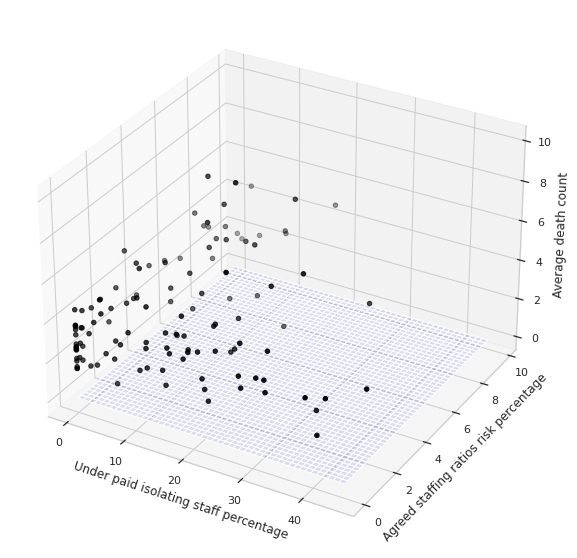

In [60]:
sn.set(style="whitegrid")

# Variables
x = merged_data_frame['underpaid_islolating_staff_percentage']
y = merged_data_frame['agreed_staffing_ratios_risk_percentage']
z = merged_data_frame['average_death_count']

# For the scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Under paid isolating staff percentage')
ax.set_ylabel('Agreed staffing ratios risk percentage')
ax.set_zlabel('Average death count')

# To determine the plane of best fit
xModel = np.linspace(min(x), max(x))
yModel = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xModel, yModel)
Z = 0.0296 - 0.0003 * X + 0.0011 * Y

# Plotting the plane of best fit and the scatter plot
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.1, color='blue')
ax.scatter(x, y, z, color='black')
plt.show()

**Perform a fitted vs residual analysis**

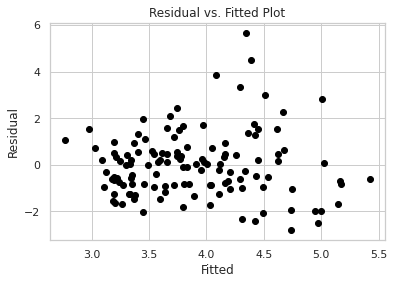

In [59]:
plt.scatter(stats.fittedvalues, stats.resid, color='black')
# adding title and labels
plt.xlabel('Fitted')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot')
plt.show()